In [2]:
import numpy as np
import pandas as pd
import tpqoa
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.tseries.offsets import DateOffset
from sklearn.linear_model import LinearRegression
import pickle
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error

In [3]:
class ARIMA_Model():
    
    def __init__(self,symbol, start, end, granularity, price):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.granularity = granularity
        self.price = price
        self.api = tpqoa.tpqoa("oanda.cfg")
        self.get_data()
        self.price_return('Close_Price')
        self.volatility_graph()
        self.histogram()
        self.dickey_fuller_test()
        self.dickey_fuller_test(1)
        self.acf_pacf_plot(30)

    def get_data(self):
        self.raw = self.api.get_history(instrument = self.symbol,start = self.start, end = self.end, 
                                        granularity = self.granularity, price = self.price)
        self.data = self.raw.copy()
        self.data.rename(columns={'c':'Close_Price'},inplace=True)
        self.data['log_returns'] = np.log(self.data['Close_Price']/self.data['Close_Price'].shift(1))
        self.data.dropna(inplace=True)

    def price_return(self,col):
        self.data[col].plot(figsize=(12,8),fontsize=15)
        plt.legend(loc='upper right',fontsize=15)
        plt.ylabel('Return',fontsize=20)
        plt.title(f'{self.symbol} Return',fontsize=20)
        plt.show()
        
    def volatility_graph(self):
        self.data['log_returns'].plot(figsize=(12,8),fontsize=15)
        plt.legend(loc='upper right',fontsize=15)
        plt.ylabel('Return',fontsize=20)
        plt.title(f'{self.symbol} Volatility',fontsize=20)
        plt.show()
        
    def histogram(self):
        self.data['log_returns'].hist(figsize=(12,8),bins=int(np.sqrt(len(self.data))))
        plt.title(f'{self.symbol} Distribution of Returns',fontsize=20)
        
    def dickey_fuller_test(self,lags=0):
        self.lags = lags
        #self.dicful_data = self.data.copy()
        if lags!=0:
            self.data[f'{self.lags}_difference'] = self.data['Close_Price'] - self.data['Close_Price'].shift(self.lags)
            self.data.dropna(inplace=True)
            result=adfuller(self.data[f'{self.lags}_difference'])
        else:
            result=adfuller(self.data['Close_Price'])
        labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
        print(f'ADF Unit Root Test Lags {self.lags}')
        for value,label in zip(result,labels):
            print(label+' : '+str(value) )
        if result[1] <= 0.05:
            print(f"Lags = {lags}, strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
        else:
            print(f"Lags = {lags}, weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        print(' ')
    
    def acf_pacf_plot(self,dflags):
        fig = plt.figure(figsize=(12,8))
        ax1 = fig.add_subplot(211)
        fig = plot_acf(self.data[f'{self.lags}_difference']**2,lags=dflags,ax=ax1)
        ax2 = fig.add_subplot(212)
        fig = plot_pacf(self.data[f'{self.lags}_difference']**2,lags=dflags,ax=ax2)
        
    def model_training(self,p,q):
        self.p = p
        self.q = q
        self.model = ARIMA(self.data['Close_Price'],order=(self.p,self.lags,self.q))
        self.model_fit=self.model.fit()
        print(self.model_fit.summary())
        filename = f'{self.symbol}_ARIMA_{self.p}-{self.lags}-{self.q}_{self.start}_{self.end}_{self.granularity}.sav'
        pickle.dump(self.model_fit, open(filename, 'wb'))
        
    def load_model(self,filename):
        self.model_fit = pickle.load(open(filename, 'rb'))
        
    def model_eval(self,st=0,en=0):
        if st == 0 and en == 0:
            self.data['forecast'] = self.model_fit.predict(dynamic = True)
        else:
            self.data['forecast'] = self.model_fit.predict(start = st,end = en,dynamic = True)
        self.data[['Close_Price','forecast']].plot(figsize=(12,8))
        
    def RMSE_Rolling_Forecast(self,train_size,p,q):
        self.p = p
        self.q = q
        self.X = self.data['Close_Price'].values
        size = int(len(self.X) * train_size)
        self.train, self.test = self.X[0:size], self.X[size:len(self.X)]
        history = [x for x in self.train]
        self.predictions = list()
        for t in range(len(self.test)):
            model = ARIMA(history, order=(self.p,self.lags,self.q))
            model_fit = model.fit()
            output = model_fit.forecast()
            yhat = output[0]
            self.predictions.append(yhat)
            obs = self.test[t]
            history.append(obs)
            print('predicted=%f, expected=%f' % (yhat, obs))
        # evaluate forecasts
        rmse = sqrt(mean_squared_error(self.test, self.predictions))
        mae = mean_absolute_error(self.test, self.predictions)
        mape = mean_absolute_percentage_error(self.test, self.predictions)
        print('Test RMSE: %.3f' % rmse)
        print('Test MAE: %.3f' % mae)
        print('Test MAPE: %.3f' % mape)
        # plot forecasts against actual outcomes
        plt.figure(figsize=(12,8))
        plt.plot(self.test)
        plt.plot(self.predictions, color='red')
        plt.title('Predictions vs Actual')
        plt.legend(loc='upper right',fontsize=15)
        plt.show()



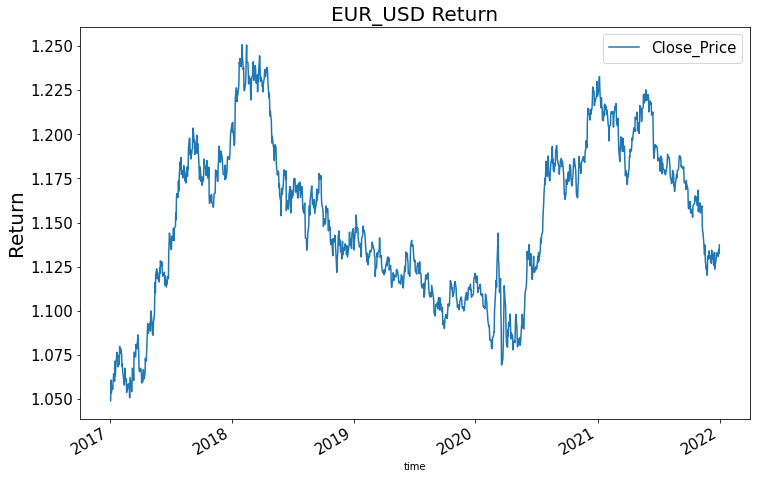

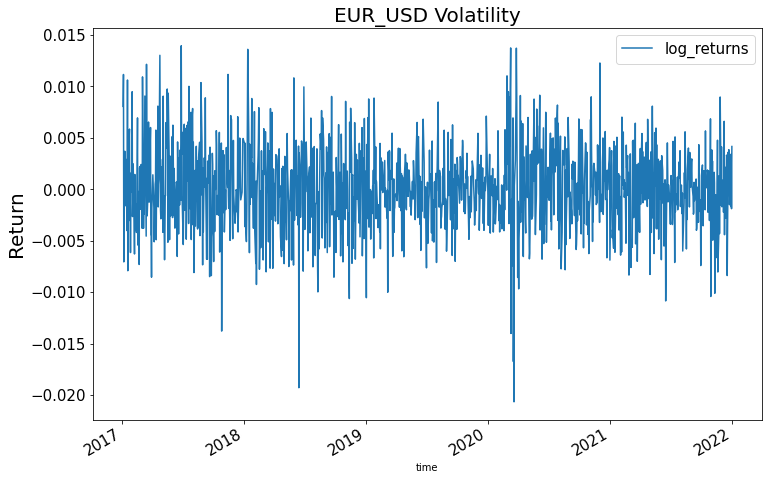

ADF Unit Root Test Lags 0
ADF Test Statistic : -2.549418115281482
p-value : 0.10390851347407326
#Lags Used : 0
Number of Observations Used : 1297
Lags = 0, weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 
 
ADF Unit Root Test Lags 1
ADF Test Statistic : -36.58836688329033
p-value : 0.0
#Lags Used : 0
Number of Observations Used : 1296
Lags = 1, strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
 


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


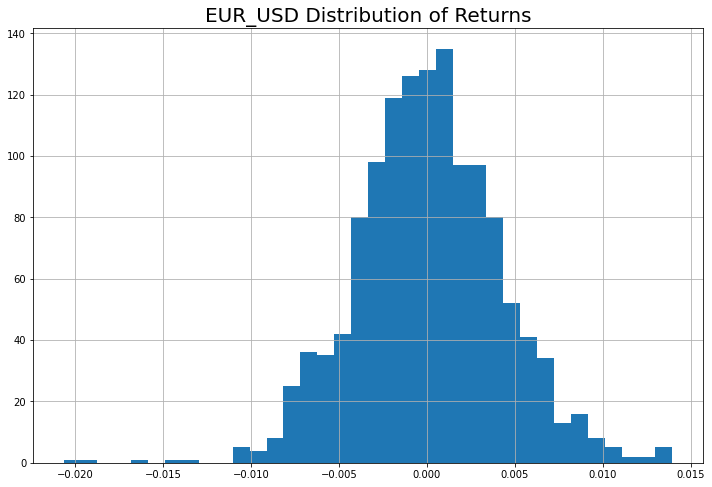

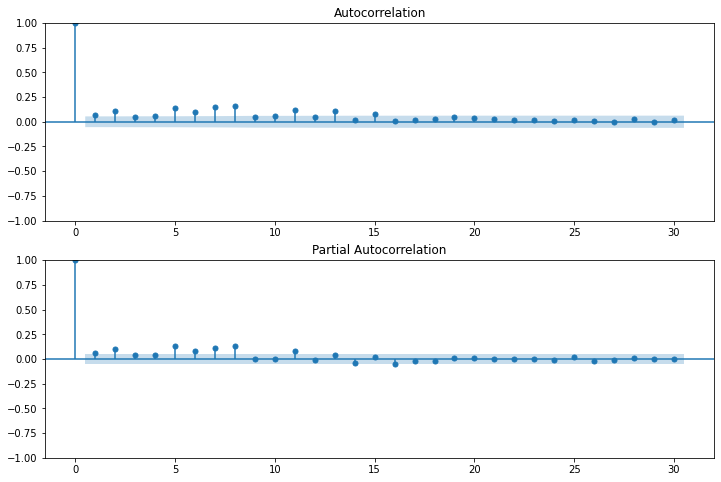

In [4]:
MLR = ARIMA_Model('EUR_USD','2017-01-01','2021-12-31','D','M')

In [6]:
#EUR_USD ARIMA 4-1-6 provided the most statistically significant results for period 2020-01-01 2021-31-12
MLR.model_training(1,0)

                               SARIMAX Results                                
Dep. Variable:            Close_Price   No. Observations:                 1297
Model:                 ARIMA(1, 1, 0)   Log Likelihood                5099.118
Date:                Fri, 15 Jul 2022   AIC                         -10194.237
Time:                        17:09:41   BIC                         -10183.903
Sample:                             0   HQIC                        -10190.359
                               - 1297                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0119      0.025     -0.466      0.641      -0.062       0.038
sigma2      2.236e-05   7.16e-07     31.232      0.000     2.1e-05    2.38e-05
Ljung-Box (L1) (Q):                   0.00   Jarque-

C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [5]:
MLR.data.to_csv('ARIMA_DATA.csv')

In [41]:
#MLR.load_model('ARIMA_6-1-1.sav')
MLR.load_model('EUR_USD_ARIMA_4-1-6.sav')

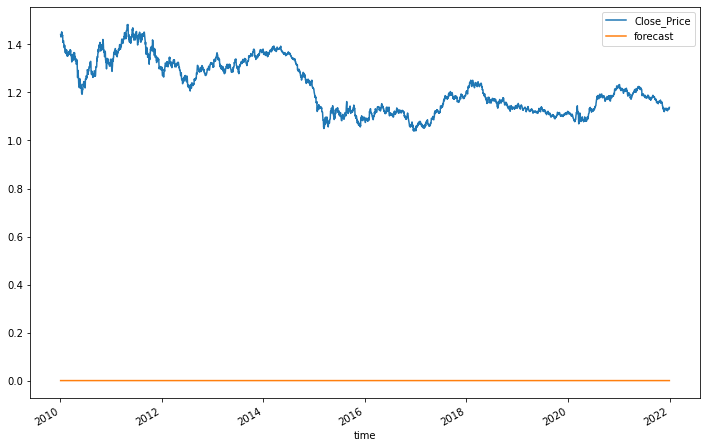

In [42]:
#MLR.model_eval(100,250)
MLR.model_eval()

C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


predicted=1.125140, expected=1.123940
predicted=1.123940, expected=1.124790
predicted=1.124790, expected=1.130940
predicted=1.130940, expected=1.127440
predicted=1.127440, expected=1.132980
predicted=1.132980, expected=1.128520
predicted=1.128520, expected=1.130020
predicted=1.130020, expected=1.134320
predicted=1.134320, expected=1.140000
predicted=1.140000, expected=1.141200
predicted=1.141200, expected=1.138370
predicted=1.138370, expected=1.142820


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.142820, expected=1.144740
predicted=1.144740, expected=1.152690
predicted=1.152690, expected=1.156980
predicted=1.156980, expected=1.159630
predicted=1.159630, expected=1.165580
predicted=1.165580, expected=1.175160
predicted=1.175160, expected=1.171610
predicted=1.171610, expected=1.179160
predicted=1.179160, expected=1.184750
predicted=1.184750, expected=1.177900
predicted=1.177900, expected=1.176220
predicted=1.176220, expected=1.180270
predicted=1.180270, expected=1.186380
predicted=1.186380, expected=1.187750
predicted=1.187750, expected=1.178600
predicted=1.178600, expected=1.173680
predicted=1.173680, expected=1.174030
predicted=1.174030, expected=1.178470
predicted=1.178470, expected=1.181420
predicted=1.181420, expected=1.184260
predicted=1.184260, expected=1.187060


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.187060, expected=1.193120
predicted=1.193120, expected=1.183820
predicted=1.183820, expected=1.186010


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.186010, expected=1.179630
predicted=1.179630, expected=1.178770
predicted=1.178770, expected=1.183440
predicted=1.183440, expected=1.183040
predicted=1.183040, expected=1.182180


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.182180, expected=1.190460
predicted=1.190460, expected=1.193620
predicted=1.193620, expected=1.191190
predicted=1.191190, expected=1.185510
predicted=1.185510, expected=1.185180


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.185180, expected=1.183830
predicted=1.183830, expected=1.181360
predicted=1.181360, expected=1.177400
predicted=1.177400, expected=1.180280


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.180280, expected=1.181450
predicted=1.181450, expected=1.184680
predicted=1.184680, expected=1.186340
predicted=1.186340, expected=1.184680


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.184680, expected=1.181660


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.181660, expected=1.184780
predicted=1.184780, expected=1.184000


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.184000, expected=1.177090
predicted=1.177090, expected=1.170770
predicted=1.170770, expected=1.166020
predicted=1.166020, expected=1.166730
predicted=1.166730, expected=1.163160
predicted=1.163160, expected=1.166340
predicted=1.166340, expected=1.174340
predicted=1.174340, expected=1.172080
predicted=1.172080, expected=1.174600
predicted=1.174600, expected=1.171670
predicted=1.171670, expected=1.178500
predicted=1.178500, expected=1.173400


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.173400, expected=1.176450
predicted=1.176450, expected=1.176020
predicted=1.176020, expected=1.182830
predicted=1.182830, expected=1.181270
predicted=1.181270, expected=1.174570
predicted=1.174570, expected=1.174620
predicted=1.174620, expected=1.170730
predicted=1.170730, expected=1.171740
predicted=1.171740, expected=1.177040
predicted=1.177040, expected=1.182220
predicted=1.182220, expected=1.185960
predicted=1.185960, expected=1.181860
predicted=1.181860, expected=1.186120
predicted=1.186120, expected=1.180940
predicted=1.180940, expected=1.179540
predicted=1.179540, expected=1.174600
predicted=1.174600, expected=1.167280
predicted=1.167280, expected=1.164800
predicted=1.164800, expected=1.164040
predicted=1.164040, expected=1.171960
predicted=1.171960, expected=1.172260
predicted=1.172260, expected=1.182840
predicted=1.182840, expected=1.187370
predicted=1.187370, expected=1.181360
predicted=1.181360, expected=1.181560
predicted=1.181560, expected=1.177830
predicted=1.

C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.185420, expected=1.187400
predicted=1.187400, expected=1.185640
predicted=1.185640, expected=1.184120
predicted=1.184120, expected=1.189240
predicted=1.189240, expected=1.191360
predicted=1.191360, expected=1.191360
predicted=1.191360, expected=1.196340
predicted=1.196340, expected=1.192490
predicted=1.192490, expected=1.207220
predicted=1.207220, expected=1.211610
predicted=1.211610, expected=1.214820
predicted=1.214820, expected=1.212180
predicted=1.212180, expected=1.210970
predicted=1.210970, expected=1.210400
predicted=1.210400, expected=1.208140
predicted=1.208140, expected=1.214180
predicted=1.214180, expected=1.211220
predicted=1.211220, expected=1.214290
predicted=1.214290, expected=1.215310
predicted=1.215310, expected=1.219980
predicted=1.219980, expected=1.226850
predicted=1.226850, expected=1.225630
predicted=1.225630, expected=1.224430
predicted=1.224430, expected=1.216300
predicted=1.216300, expected=1.218560
predicted=1.218560, expected=1.218490
predicted=1.

C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.230000, expected=1.221560
predicted=1.221560, expected=1.225250
predicted=1.225250, expected=1.229860
predicted=1.229860, expected=1.232720
predicted=1.232720, expected=1.226920
predicted=1.226920, expected=1.222100
predicted=1.222100, expected=1.215120
predicted=1.215120, expected=1.220790
predicted=1.220790, expected=1.215800
predicted=1.215800, expected=1.215460
predicted=1.215460, expected=1.208040
predicted=1.208040, expected=1.207730
predicted=1.207730, expected=1.212860
predicted=1.212860, expected=1.210620
predicted=1.210620, expected=1.216760
predicted=1.216760, expected=1.217180
predicted=1.217180, expected=1.214160
predicted=1.214160, expected=1.216000
predicted=1.216000, expected=1.211200
predicted=1.211200, expected=1.212180
predicted=1.212180, expected=1.213760
predicted=1.213760, expected=1.206020
predicted=1.206020, expected=1.204370
predicted=1.204370, expected=1.203550
predicted=1.203550, expected=1.196240
predicted=1.196240, expected=1.204660
predicted=1.

C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.206360, expected=1.197230
predicted=1.197230, expected=1.191300
predicted=1.191300, expected=1.184600
predicted=1.184600, expected=1.190160
predicted=1.190160, expected=1.192860
predicted=1.192860, expected=1.198560
predicted=1.198560, expected=1.195250
predicted=1.195250, expected=1.193020
predicted=1.193020, expected=1.190270
predicted=1.190270, expected=1.197940
predicted=1.197940, expected=1.191600
predicted=1.191600, expected=1.190420
predicted=1.190420, expected=1.193260
predicted=1.193260, expected=1.184930
predicted=1.184930, expected=1.181280
predicted=1.181280, expected=1.176440
predicted=1.176440, expected=1.179410
predicted=1.179410, expected=1.176500
predicted=1.176500, expected=1.171580
predicted=1.171580, expected=1.173080
predicted=1.173080, expected=1.177740
predicted=1.177740, expected=1.176020
predicted=1.176020, expected=1.181230
predicted=1.181672, expected=1.187650


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.187396, expected=1.187180


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.187380, expected=1.191540


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.191118, expected=1.189980


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.190248, expected=1.191140


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.190616, expected=1.194870


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.195122, expected=1.197900
predicted=1.197161, expected=1.196650


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.196825, expected=1.198220


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.197189, expected=1.203690
predicted=1.203690, expected=1.203640
predicted=1.203640, expected=1.203490
predicted=1.203490, expected=1.201480
predicted=1.201480, expected=1.209680


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.209425, expected=1.208590


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.208344, expected=1.209160


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.208586, expected=1.212580


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.211863, expected=1.211990


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.211147, expected=1.202000
predicted=1.202000, expected=1.206380
predicted=1.206380, expected=1.201330
predicted=1.201330, expected=1.200480
predicted=1.200480, expected=1.206530
predicted=1.206530, expected=1.216320
predicted=1.216320, expected=1.212880
predicted=1.212880, expected=1.214830
predicted=1.214830, expected=1.207260
predicted=1.207260, expected=1.207900
predicted=1.207900, expected=1.214570
predicted=1.214570, expected=1.215000
predicted=1.215000, expected=1.222250
predicted=1.222250, expected=1.217580
predicted=1.217580, expected=1.222860
predicted=1.222860, expected=1.218170
predicted=1.218170, expected=1.221660
predicted=1.221660, expected=1.225220
predicted=1.225220, expected=1.219290
predicted=1.219290, expected=1.219410
predicted=1.219410, expected=1.219210
predicted=1.219210, expected=1.222580
predicted=1.222580, expected=1.221380
predicted=1.221380, expected=1.221040
predicted=1.221040, expected=1.212710
predicted=1.212710, expected=1.216680
predicted=1.

C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.177891, expected=1.179480


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.179522, expected=1.177130


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.176967, expected=1.177170


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.177888, expected=1.180300


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.179908, expected=1.181610


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.182041, expected=1.184250


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.184208, expected=1.188700
predicted=1.188330, expected=1.186710


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.186738, expected=1.187200
predicted=1.186534, expected=1.186490
predicted=1.186699, expected=1.183680
predicted=1.183345, expected=1.183240
predicted=1.183302, expected=1.176160
predicted=1.176095, expected=1.173580
predicted=1.173557, expected=1.172060
predicted=1.172067, expected=1.173950
predicted=1.174500, expected=1.172970
predicted=1.172993, expected=1.179540
predicted=1.179985, expected=1.177650
predicted=1.177679, expected=1.170840
predicted=1.171269, expected=1.171060
predicted=1.170287, expected=1.167620
predicted=1.168441, expected=1.169900
predicted=1.169678, expected=1.174600
predicted=1.175378, expected=1.175730
predicted=1.175341, expected=1.177240
predicted=1.177634, expected=1.175220


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.174540, expected=1.179440


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.179058, expected=1.179690
predicted=1.178567, expected=1.180880


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.180617, expected=1.184000
predicted=1.183913, expected=1.187500


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.186675, expected=1.187910


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.188217, expected=1.187090


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.186456, expected=1.184220
predicted=1.184401, expected=1.181580


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.181016, expected=1.182380


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.182808, expected=1.181070
predicted=1.181142, expected=1.181030


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.181148, expected=1.180400


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.180102, expected=1.181580
predicted=1.180056, expected=1.176880
predicted=1.176809, expected=1.172430


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.172700, expected=1.172670


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.172325, expected=1.172550
predicted=1.172990, expected=1.168800


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.168898, expected=1.173880
predicted=1.173382, expected=1.172060
predicted=1.173410, expected=1.169530
predicted=1.169530, expected=1.168340
predicted=1.168340, expected=1.159710


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.159816, expected=1.157760
predicted=1.158524, expected=1.159300
predicted=1.160263, expected=1.162040
predicted=1.162040, expected=1.159780
predicted=1.159780, expected=1.155670
predicted=1.155670, expected=1.155360


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.155360, expected=1.157440
predicted=1.157940, expected=1.155320


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.155955, expected=1.153020


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.153077, expected=1.159580


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.159471, expected=1.159710


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.159664, expected=1.159900


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.160266, expected=1.161120


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.161043, expected=1.163300


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.163118, expected=1.165100


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.165147, expected=1.162490


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.162179, expected=1.164590


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.164387, expected=1.161060


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.161020, expected=1.159640
predicted=1.159276, expected=1.160330


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.160469, expected=1.168300


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.168292, expected=1.156190
predicted=1.155125, expected=1.160620
predicted=1.160609, expected=1.157990


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.157490, expected=1.161170
predicted=1.162248, expected=1.155440
predicted=1.155440, expected=1.156810
predicted=1.156810, expected=1.158720
predicted=1.158720, expected=1.159440
predicted=1.159440, expected=1.147780
predicted=1.147780, expected=1.144930
predicted=1.144930, expected=1.144330
predicted=1.144330, expected=1.136760
predicted=1.137879, expected=1.132040
predicted=1.130762, expected=1.131890
predicted=1.132974, expected=1.137300
predicted=1.137484, expected=1.128190
predicted=1.128969, expected=1.123440
predicted=1.123254, expected=1.124920
predicted=1.125480, expected=1.120080
predicted=1.120426, expected=1.120920


C:\Users\Panos2\anaconda3\envs\tomouni\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=1.121437, expected=1.131020
predicted=1.131318, expected=1.129250
predicted=1.130177, expected=1.133920
predicted=1.133849, expected=1.132000
predicted=1.132168, expected=1.130100
predicted=1.130247, expected=1.131090
predicted=1.130772, expected=1.128570
predicted=1.128975, expected=1.126860
predicted=1.126636, expected=1.134330
predicted=1.134463, expected=1.129330
predicted=1.129656, expected=1.131780
predicted=1.131640, expected=1.128620
predicted=1.128495, expected=1.125740
predicted=1.126030, expected=1.129480
predicted=1.129102, expected=1.133060
predicted=1.133566, expected=1.123600
predicted=1.123625, expected=1.127660
predicted=1.127363, expected=1.128410
predicted=1.128594, expected=1.132760
predicted=1.133103, expected=1.132750
predicted=1.132477, expected=1.131050
predicted=1.131300, expected=1.132740
predicted=1.132385, expected=1.130840
predicted=1.130957, expected=1.134720
predicted=1.134564, expected=1.132580


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted=1.132605, expected=1.137300
Test RMSE: 0.004
Test MAE: 0.003
Test MAPE: 0.003


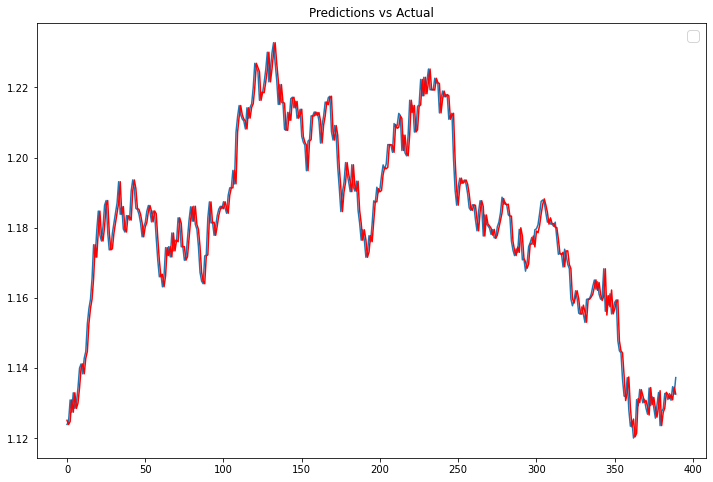

In [5]:
MLR.RMSE_Rolling_Forecast(0.7,4,6)

In [6]:
MLR.data

,volume,complete,o,h,l,Close_Price,log_returns,1_difference
time,,,,,,,,
2010-01-03 22:00:00+00:00,42031,True,1.43050,1.44565,1.42583,1.44136,0.007521,0.01080
2010-01-04 22:00:00+00:00,45159,True,1.44132,1.44845,1.43473,1.43660,-0.003308,-0.00476
2010-01-05 22:00:00+00:00,45142,True,1.43675,1.44350,1.42840,1.44087,0.002968,0.00427
2010-01-06 22:00:00+00:00,42005,True,1.44083,1.44476,1.43001,1.43089,-0.006950,-0.00998
2010-01-07 22:00:00+00:00,47542,True,1.43099,1.44393,1.42653,1.44105,0.007075,0.01016
...,...,...,...,...,...,...,...,...
2021-12-26 22:00:00+00:00,28776,True,1.13233,1.13353,1.13037,1.13284,0.001139,0.00129
2021-12-27 22:00:00+00:00,33197,True,1.13332,1.13342,1.12904,1.13092,-0.001696,-0.00192
2021-12-28 22:00:00+00:00,51721,True,1.13148,1.13697,1.12745,1.13480,0.003425,0.00388


In [5]:
MLR.api.get_account_summary()

{'id': '101-012-22322939-001',
 'alias': 'Primary',
 'currency': 'EUR',
 'balance': '511100028.8576',
 'createdByUserID': 22322939,
 'createdTime': '2022-05-06T15:46:57.835020174Z',
 'guaranteedStopLossOrderMode': 'ALLOWED',
 'pl': '28.8576',
 'resettablePL': '28.8576',
 'resettablePLTime': '0',
 'financing': '0.0',
 'commission': '0.0',
 'guaranteedExecutionFees': '0.0',
 'marginRate': '0.02',
 'openTradeCount': 0,
 'openPositionCount': 0,
 'pendingOrderCount': 0,
 'hedgingEnabled': False,
 'unrealizedPL': '0.0',
 'NAV': '511100028.8576',
 'marginUsed': '0.0',
 'marginAvailable': '511100028.8576',
 'positionValue': '0.0',
 'marginCloseoutUnrealizedPL': '0.0',
 'marginCloseoutNAV': '511100028.8576',
 'marginCloseoutMarginUsed': '0.0',
 'marginCloseoutPercent': '0.0',
 'marginCloseoutPositionValue': '0.0',
 'withdrawalLimit': '511100028.8576',
 'marginCallMarginUsed': '0.0',
 'marginCallPercent': '0.0',
 'lastTransactionID': '55'}